In [ ]:
import nibabel as nib
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, LeakyReLU, Flatten, Input, BatchNormalization, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

def load_mri_image(filepath):
    # Load the MRI scan using nibabel (for NIfTI files)
    img = nib.load(filepath)
    img_data = img.get_fdata()

    # Normalize the image and resize to 256x256
    img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))
    img_resized = cv2.resize(img_data, (256, 256))

    return img_resized

def load_mask(filepath):
    # Load the binary mask
    mask = nib.load(filepath).get_fdata()
    mask_resized = cv2.resize(mask, (256, 256))
    mask_resized = (mask_resized > 0).astype(np.uint8)  # Binarize the mask
    return mask_resized


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Function to build the modified U-Net model for brain tumor segmentation
def modified_unet_brain_tumor(input_shape=(256, 256, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)

    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = layers.MaxPooling2D((2, 2))(conv5)

    # Bottleneck (8x8x128)
    bottleneck = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool5)
    bottleneck = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(bottleneck)

    # Decoder
    up6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    merge6 = layers.concatenate([up6, conv5])
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([up7, conv4])
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([up8, conv3])
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([up9, conv2])
    conv9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

    up10 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9)
    merge10 = layers.concatenate([up10, conv1])
    conv10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge10)
    conv10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    # Output layer for binary classification (tumor or non-tumor)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv10)

    model = models.Model(inputs, outputs)

    return model

model = modified_unet_brain_tumor()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


In [ ]:
def build_generator():
    def residual_block(input_layer, filters):
        x = Conv2D(filters, kernel_size=3, padding='same')(input_layer)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        return add([x, input_layer])

    input_layer = Input(shape=(None, None, 3))
    x = Conv2D(64, kernel_size=9, padding='same')(input_layer)
    x = Activation('relu')(x)

    for _ in range(16):
        x = residual_block(x, 64)

    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(x)
    x = Activation('relu')(x)

    output_layer = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)

    return Model(input_layer, output_layer)





In [ ]:
def build_discriminator():
    input_layer = Input(shape=(None, None, 3))
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)

    output_layer = Dense(1, activation='sigmoid')(x)

    return Model(input_layer, output_layer)


In [ ]:
def build_srgan(generator, discriminator):
    input_layer = Input(shape=(None, None, 3))
    generated_image = generator(input_layer)
    discriminator.trainable = False
    validity = discriminator(generated_image)

    return Model(input_layer, [validity, generated_image])

generator = build_generator()
discriminator = build_discriminator()

srgan = build_srgan(generator, discriminator)

generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

srgan.compile(loss=['binary_crossentropy', 'mse'], optimizer=Adam(0.0002, 0.5))

In [ ]:
epochs = 10000
batch_size = 16

for epoch in range(epochs):
    idx = np.random.randint(0, low_res_images.shape[0], batch_size)
    low_res_imgs = low_res_images[idx]
    high_res_imgs = high_res_images[idx]

    generated_high_res_imgs = generator.predict(low_res_imgs)

    real_validity = np.ones((batch_size, 1))
    fake_validity = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(high_res_imgs, real_validity)
    d_loss_fake = discriminator.train_on_batch(generated_high_res_imgs, fake_validity)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = srgan.train_on_batch(low_res_imgs, [real_validity, high_res_imgs])

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")


In [ ]:
low_res_image = load_images_from_folder('test_folder', target_size=(64, 64))[0]
generated_image = generator.predict(np.expand_dims(low_res_image, axis=0))[0]



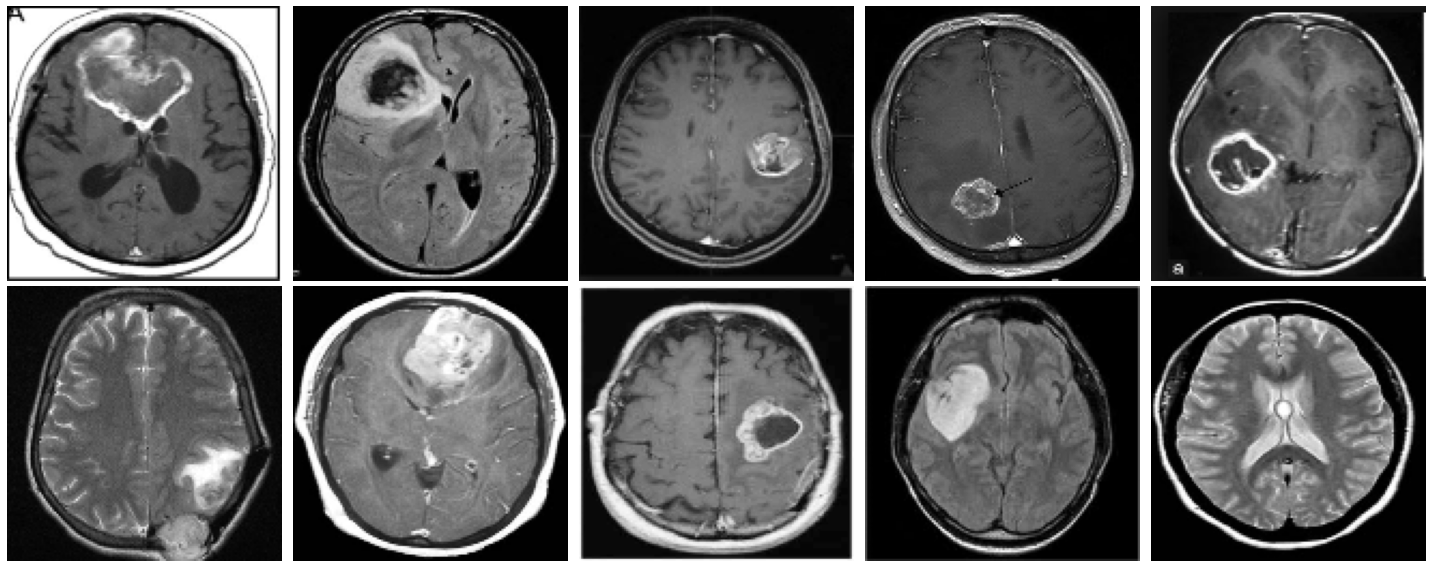

In [ ]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

100%|██████████| 3750/3750 [05:29<00:00, 11.39it/s]


EPOCH: 1 Generator Loss: 6.3446 Discriminator Loss: 0.0478


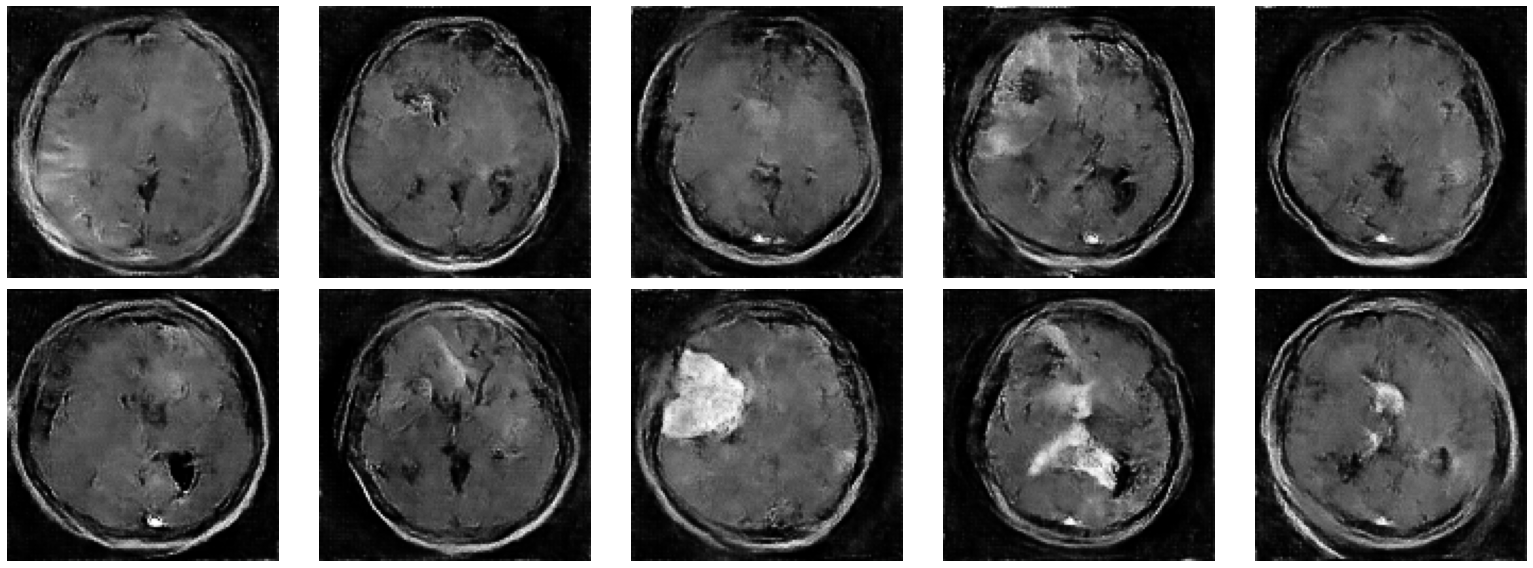

100%|██████████| 3750/3750 [05:20<00:00, 11.71it/s]


EPOCH: 2 Generator Loss: 5.9254 Discriminator Loss: 0.0023


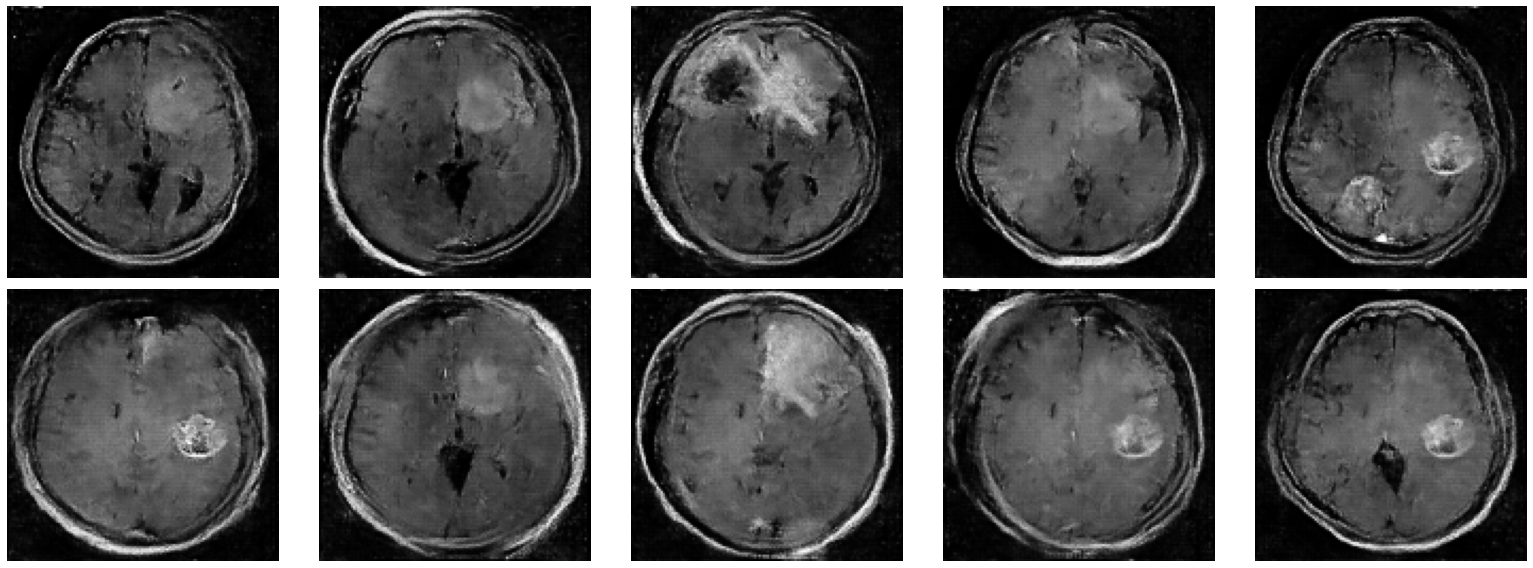

100%|██████████| 3750/3750 [05:17<00:00, 11.80it/s]


EPOCH: 3 Generator Loss: 5.2215 Discriminator Loss: 0.0408


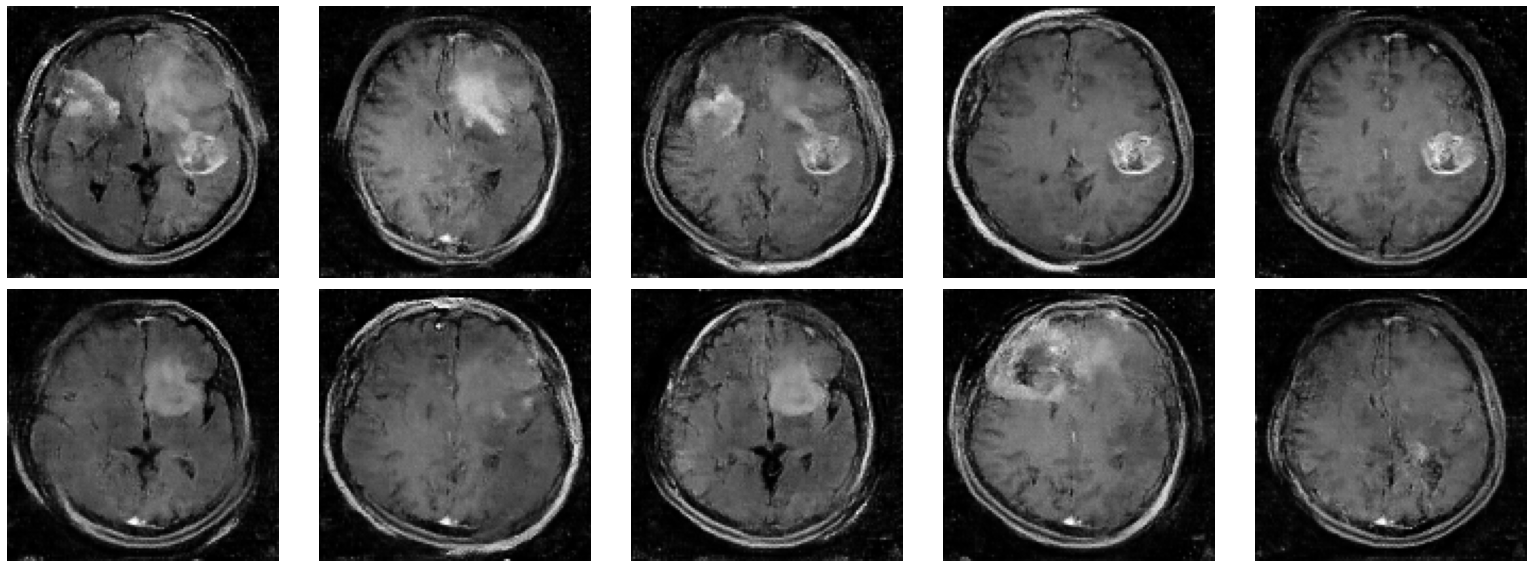

100%|██████████| 3750/3750 [05:18<00:00, 11.79it/s]


EPOCH: 4 Generator Loss: 3.4690 Discriminator Loss: 0.0161


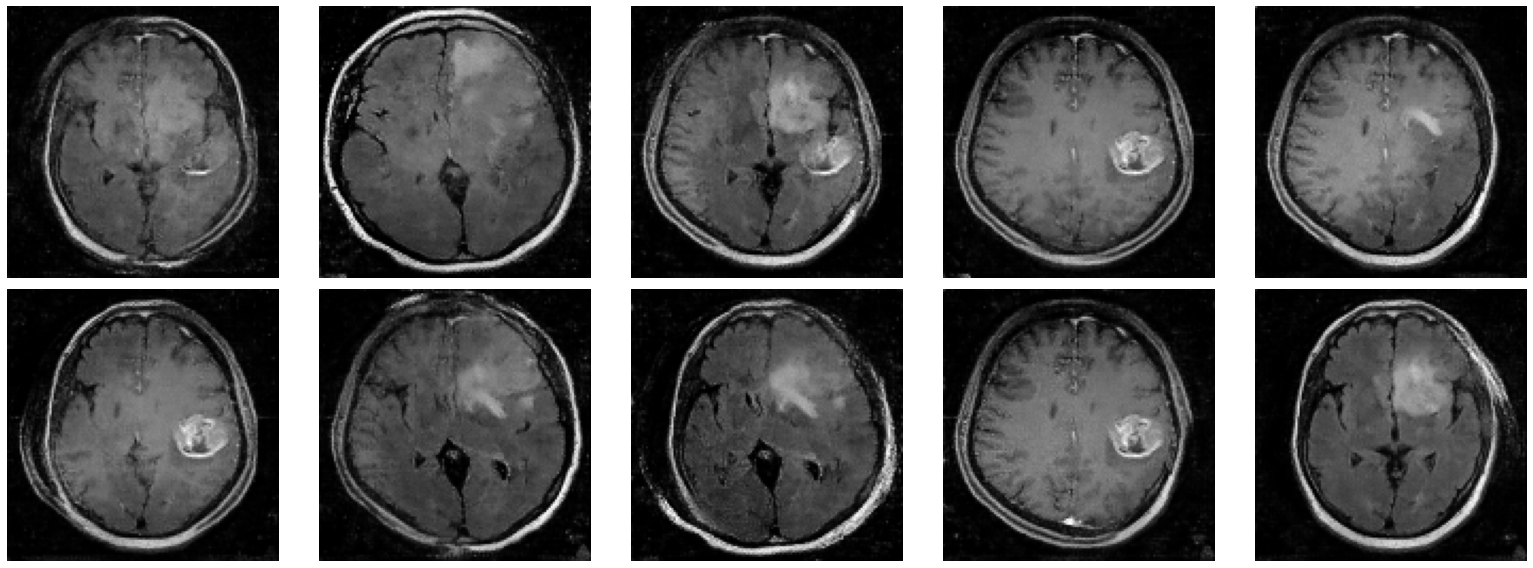

100%|██████████| 3750/3750 [05:19<00:00, 11.74it/s]


EPOCH: 5 Generator Loss: 3.9375 Discriminator Loss: 0.0378


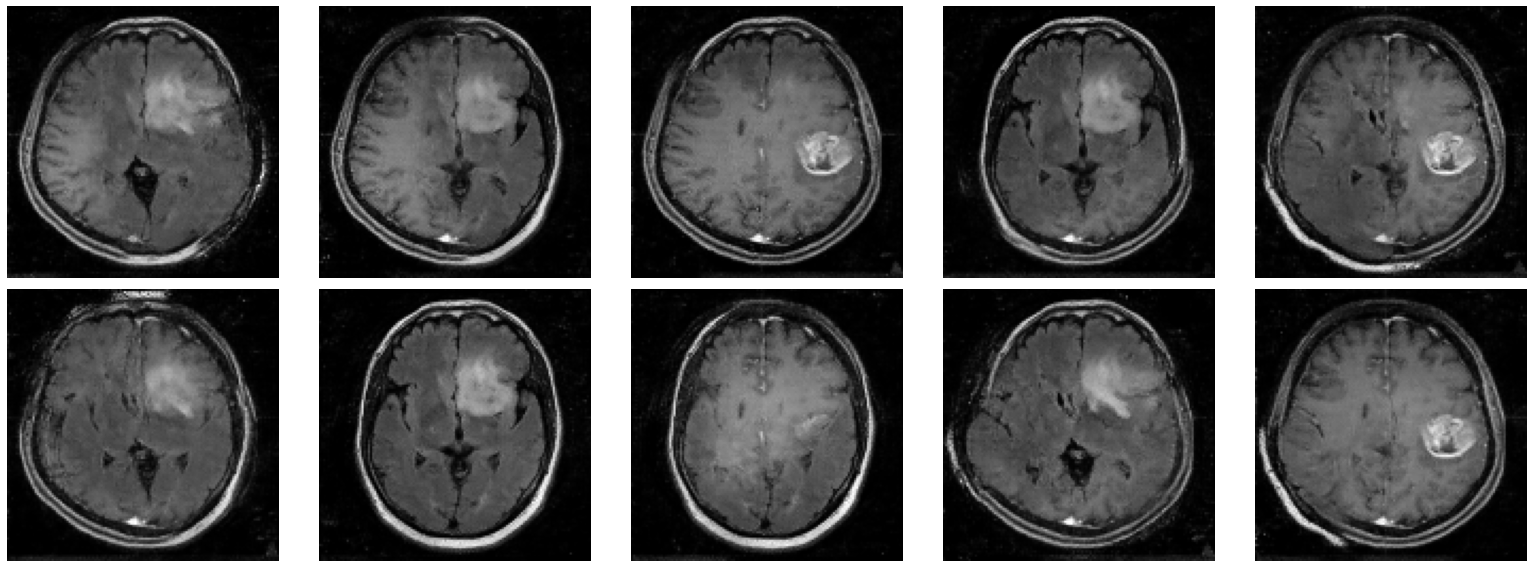

100%|██████████| 3750/3750 [05:22<00:00, 11.63it/s]


EPOCH: 6 Generator Loss: 5.8280 Discriminator Loss: 0.0424


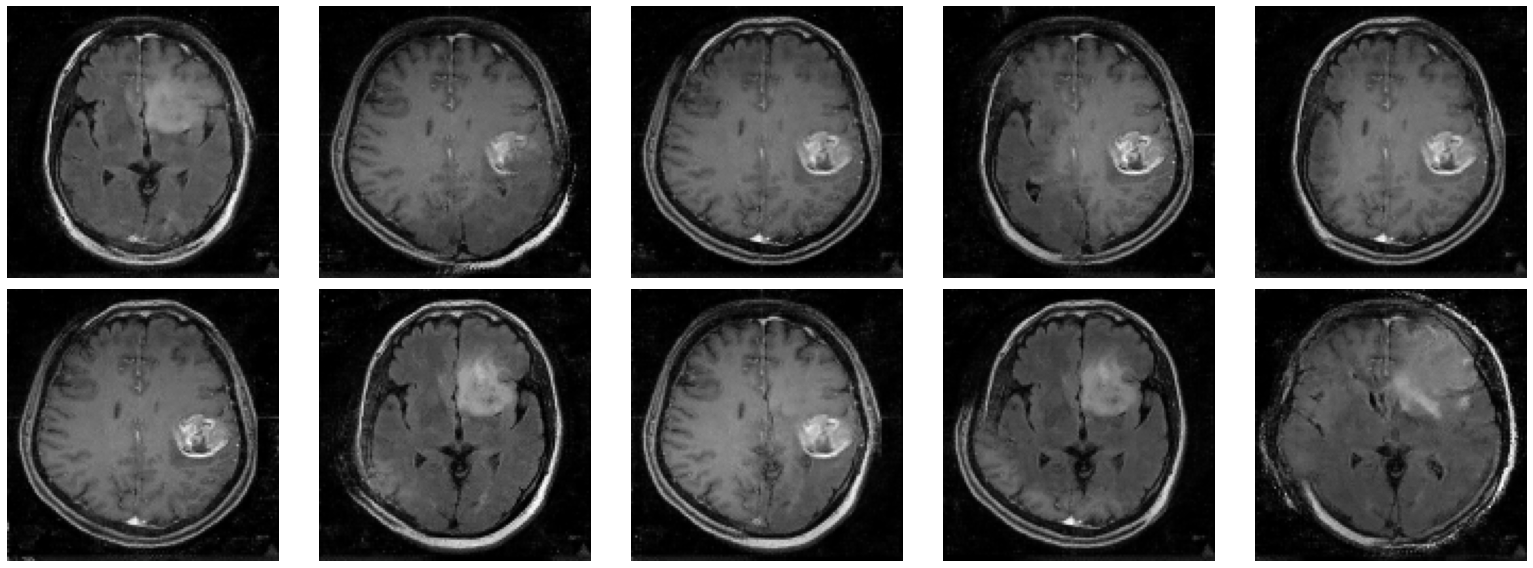

100%|██████████| 3750/3750 [05:22<00:00, 11.64it/s]


EPOCH: 7 Generator Loss: 2.1251 Discriminator Loss: 0.4679


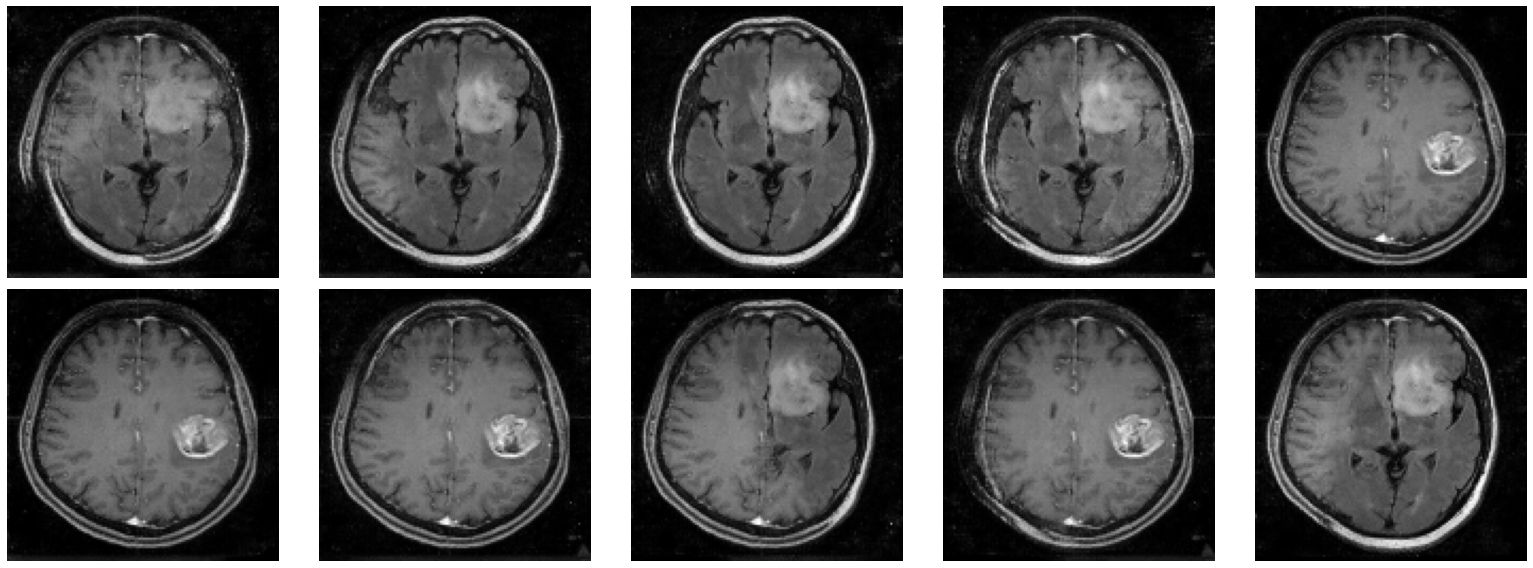

100%|██████████| 3750/3750 [05:22<00:00, 11.61it/s]


EPOCH: 8 Generator Loss: 5.6223 Discriminator Loss: 0.0714


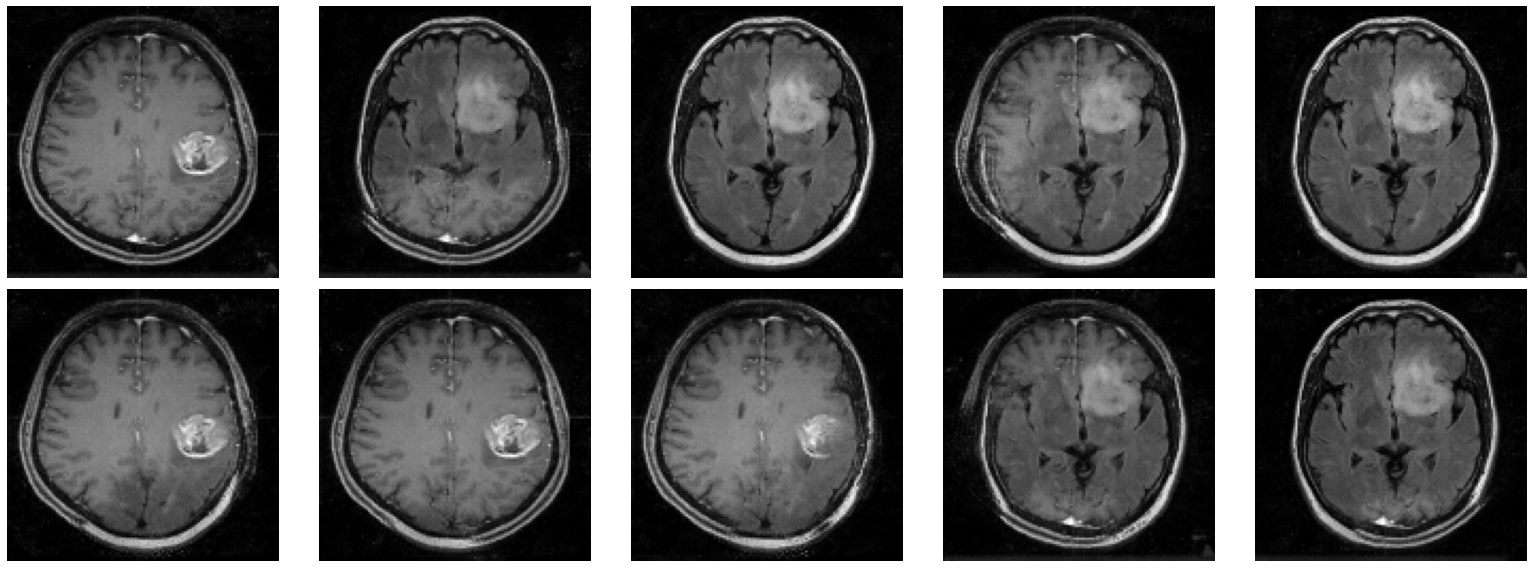

100%|██████████| 3750/3750 [05:22<00:00, 11.61it/s]


EPOCH: 9 Generator Loss: 5.0983 Discriminator Loss: 0.0918


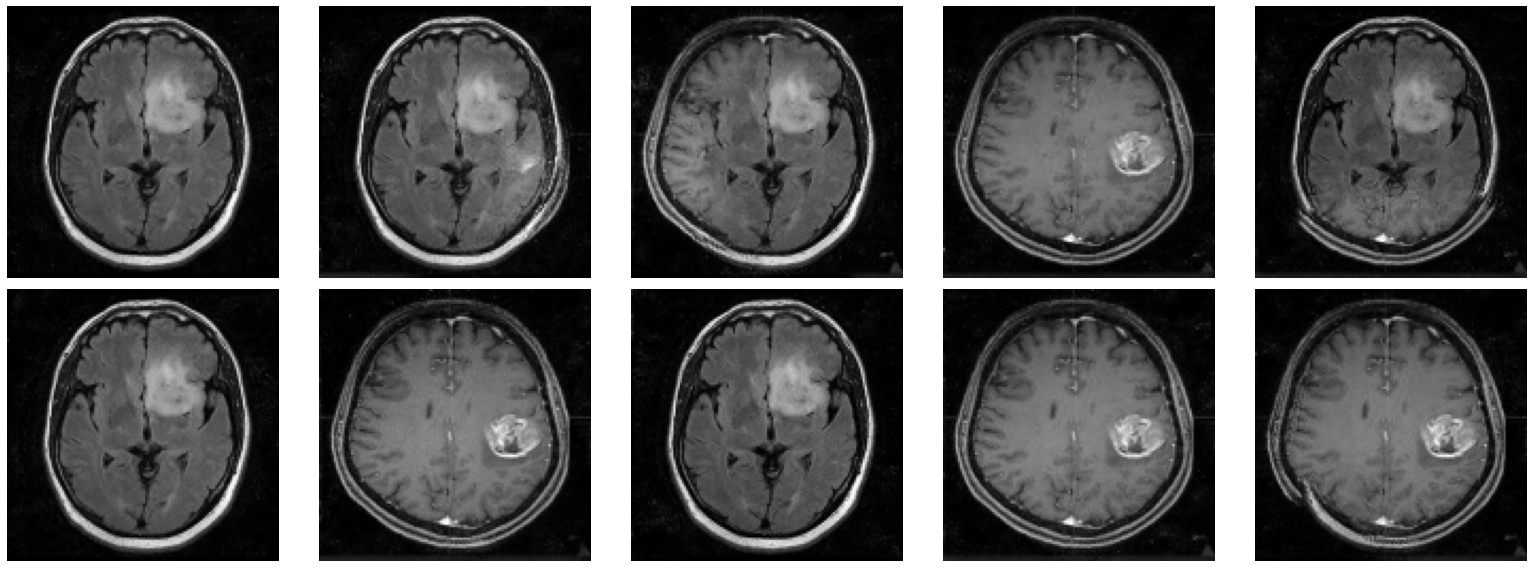

100%|██████████| 3750/3750 [05:27<00:00, 11.44it/s]


EPOCH: 10 Generator Loss: 3.4853 Discriminator Loss: 0.0883


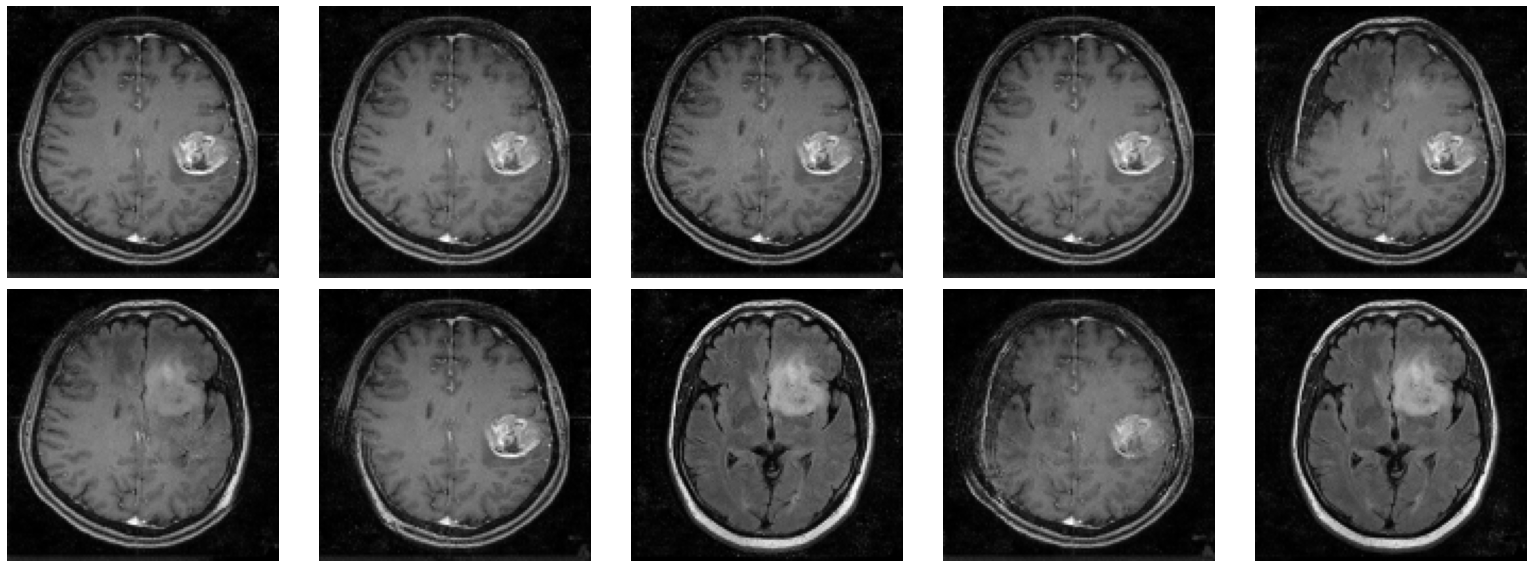

In [ ]:
np.random.seed(SEED)
for epoch in range(10):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)

        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))